# **Experiment Notebook**



## Context


*This project aims in Helping the Marketing Team to send customized marketing emails to groups of customers presenting similar spending behaviors using K-Means Clustering.*

### 0. Import Packages

In [1]:
! pip install -r https://raw.githubusercontent.com/aso-uts/labs_datasets/main/36106-mlaa/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.1.1 which is incompatible.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import altair as alt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score

### 1.   Load Dataset

In [14]:
file_url = '/content/transactions.csv'

In [15]:
df = pd.read_csv(file_url)

### 2. Explore Dataset

In [16]:
print(df.shape)

(398591, 10)


In [17]:
# Check for duplicate rows in dataset
duplicate_rows = df[df.duplicated()]

if duplicate_rows.empty:
    print("No duplicate rows found in the dataset.")
else:
    print("Duplicate rows found in dataset:")
    print(duplicate_rows)

No duplicate rows found in the dataset.


*There are no common rows that are completely identical across the datasets, hence no dupication.*

In [18]:
df.head()

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,4218196001337,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522
1,4218196001337,888022315787,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359
2,4218196001337,888022315787,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327
3,4218196001337,888022315787,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,Lambert-Cooper,39.656925,-75.802342
4,4218196001337,888022315787,35fd7db657d7e30dd608c37f7798186e,1549840400,gas_transport,71.89,0,Griffith LLC,40.313342,-74.220434


In [19]:
# summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,398591.0,4.949321e+17,1.414717e+18,6.040027e+10,1.800509e+14,3.532537e+15,4.646726e+15,4.896332e+18
acct_num,398591.0,5.235772e+11,2.902318e+11,6.931334e+09,2.982298e+11,5.129898e+11,7.992410e+11,9.993899e+11
unix_time,398591.0,1.628207e+09,3.739542e+07,1.546261e+09,1.597276e+09,1.643075e+09,1.659186e+09,1.672492e+09
amt,398591.0,6.592117e+01,1.711400e+02,1.000000e+00,8.670000e+00,4.424000e+01,8.081000e+01,3.141268e+04
is_fraud,398591.0,1.359790e-03,3.685029e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
merch_lat,398591.0,3.754982e+01,6.393764e+00,2.029438e+01,3.358193e+01,3.834107e+01,4.160605e+01,6.577610e+01
merch_long,398591.0,-9.301628e+01,2.048074e+01,-1.603447e+02,-9.726469e+01,-8.597103e+01,-7.967023e+01,-6.724632e+01


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398591 entries, 0 to 398590
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   cc_num      398591 non-null  int64  
 1   acct_num    398591 non-null  int64  
 2   trans_num   398591 non-null  object 
 3   unix_time   398591 non-null  int64  
 4   category    398591 non-null  object 
 5   amt         398591 non-null  float64
 6   is_fraud    398591 non-null  int64  
 7   merchant    398591 non-null  object 
 8   merch_lat   398591 non-null  float64
 9   merch_long  398591 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 30.4+ MB


In [21]:
# Checking for missing values
df.isnull().sum()

cc_num        0
acct_num      0
trans_num     0
unix_time     0
category      0
amt           0
is_fraud      0
merchant      0
merch_lat     0
merch_long    0
dtype: int64

*There are no missing values in the dataset.*

### 3. Explore Target variable

*For the chosen topic of clustering customers based on their spending behaviors to help the marketing team send customized marketing emails, there is no "target variable" in the traditional sense as used in supervised learning. Instead, clustering is an unsupervised learning technique where the goal is to group similar data points together.*
*In this context, the target variable is essentially the outcome of the clustering process, which are the clusters or segments that represent groups of customers with similar spending behaviors.*

### 4. Explore Variables of Interest

##### Descriptive statistics

In [22]:
print(df.describe())

             cc_num      acct_num     unix_time            amt      is_fraud  \
count  3.985910e+05  3.985910e+05  3.985910e+05  398591.000000  398591.00000   
mean   4.949321e+17  5.235772e+11  1.628207e+09      65.921171       0.00136   
std    1.414717e+18  2.902318e+11  3.739542e+07     171.139997       0.03685   
min    6.040027e+10  6.931334e+09  1.546261e+09       1.000000       0.00000   
25%    1.800509e+14  2.982298e+11  1.597276e+09       8.670000       0.00000   
50%    3.532537e+15  5.129898e+11  1.643075e+09      44.240000       0.00000   
75%    4.646726e+15  7.992410e+11  1.659186e+09      80.810000       0.00000   
max    4.896332e+18  9.993899e+11  1.672492e+09   31412.680000       1.00000   

           merch_lat     merch_long  
count  398591.000000  398591.000000  
mean       37.549817     -93.016281  
std         6.393764      20.480736  
min        20.294378    -160.344659  
25%        33.581928     -97.264690  
50%        38.341065     -85.971030  
75%        41



* The average transaction amount is $65.92. High maximum value compared to the mean and the 75th percentile (80.81)
* The average is_fraud value of 0.00136 indicates that a small fraction (0.136%) of transactions are fraudulent
* The average latitude is 37.55 and the average longitude is -93.02, which are within the geographical bounds of the United States.
* The standard deviation of time shows some spread around the mean transaction time, but this is expected given a three-year period of transactional data from customers.





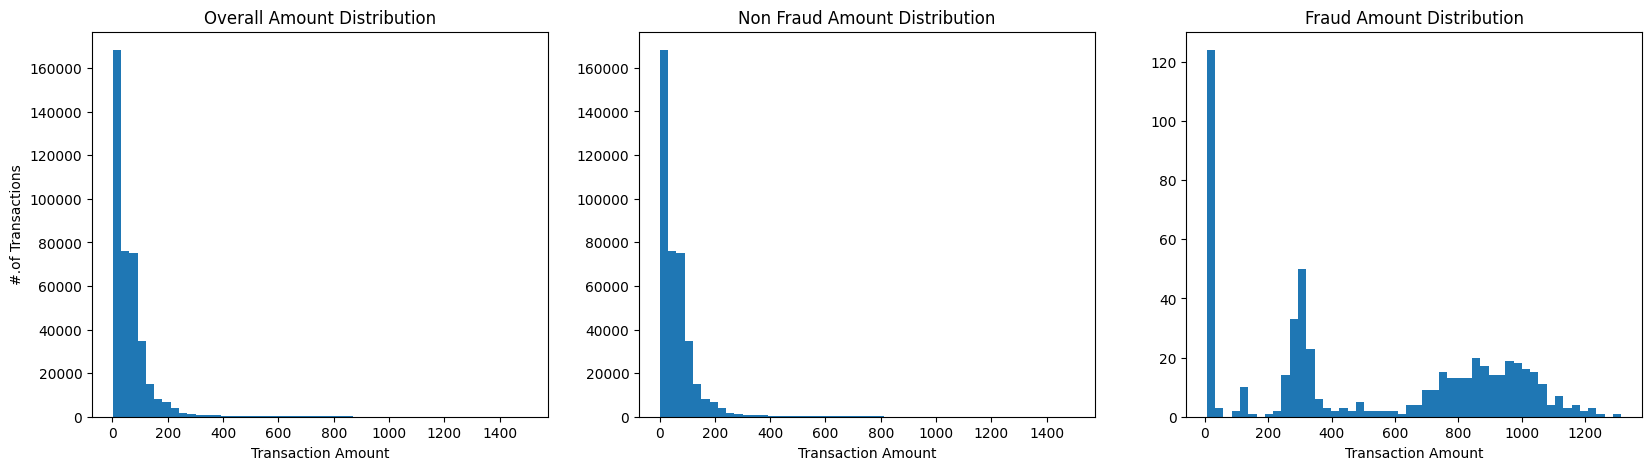

In [23]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(df[df['amt']<=1500]['amt'], bins=50)
ax[1].hist(df[(df['is_fraud']==0) & (df['amt']<=1500)]['amt'], bins=50)
ax[2].hist(df[(df['is_fraud']==1) & (df['amt']<=1500)]['amt'], bins=50)

ax[0].set_title('Overall Amount Distribution')
ax[1].set_title('Non Fraud Amount Distribution')
ax[2].set_title('Fraud Amount Distribution')

ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('#.of Transactions')

ax[1].set_xlabel('Transaction Amount')
ax[2].set_xlabel('Transaction Amount')
plt.show()

##### Distribution of Transaction Amounts

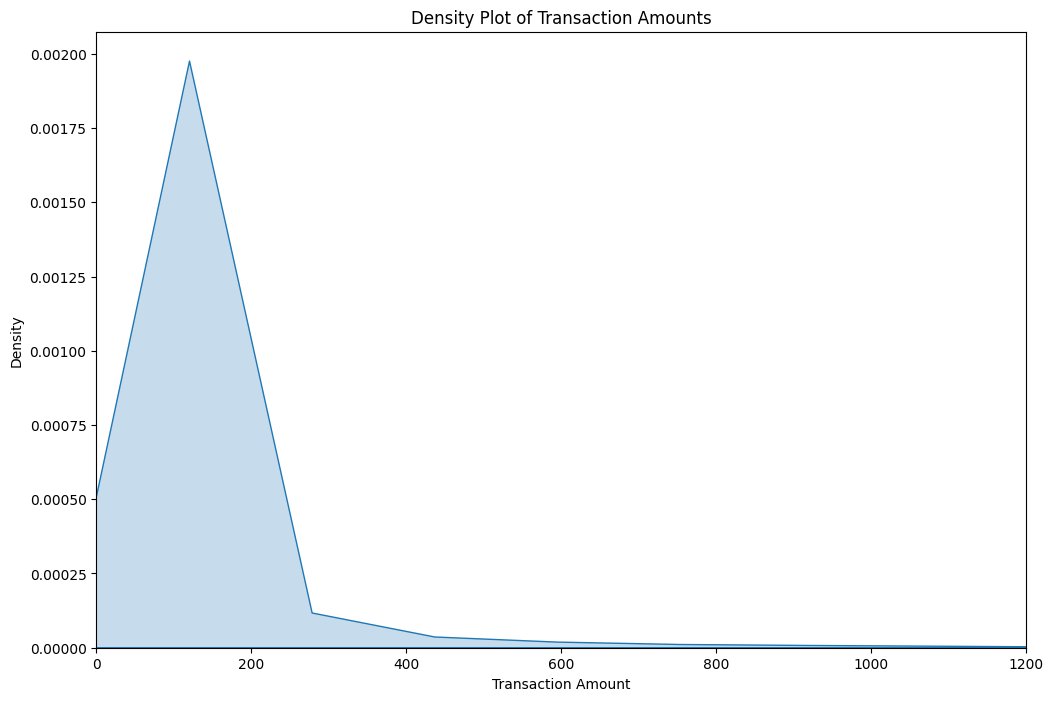

In [24]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='amt', fill=True)
plt.title('Density Plot of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.xlim(0, 1200)
plt.show()

##### Box Plot of Transaction Amounts

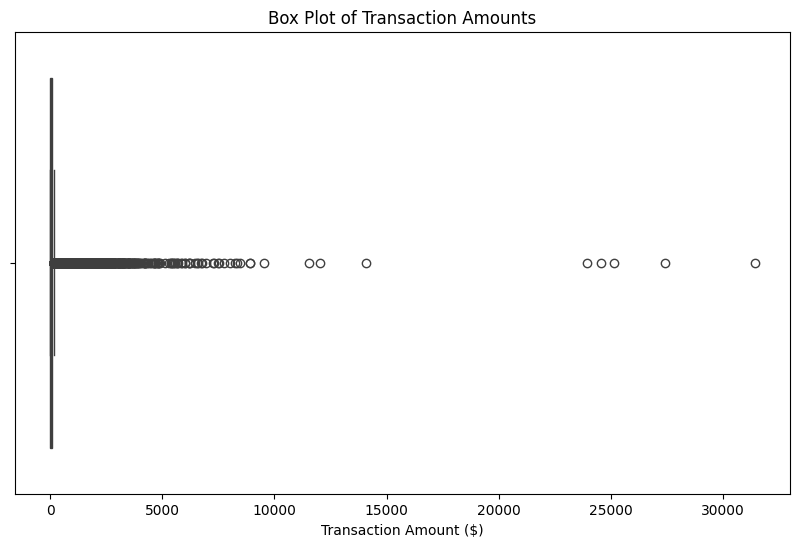

In [25]:
plt.figure(figsize=(10,6))
sns.boxplot(x='amt', data=df)
plt.title('Box Plot of Transaction Amounts')
plt.xlabel('Transaction Amount ($)')
plt.show()

*Transactions with amounts significantly higher than the 75th percentile could be considered outliers. Specifically, the maximum value is much higher than the 75th percentile, suggesting potential outliers.*

#### Category-wise Analysis

##### Count of transactions per category

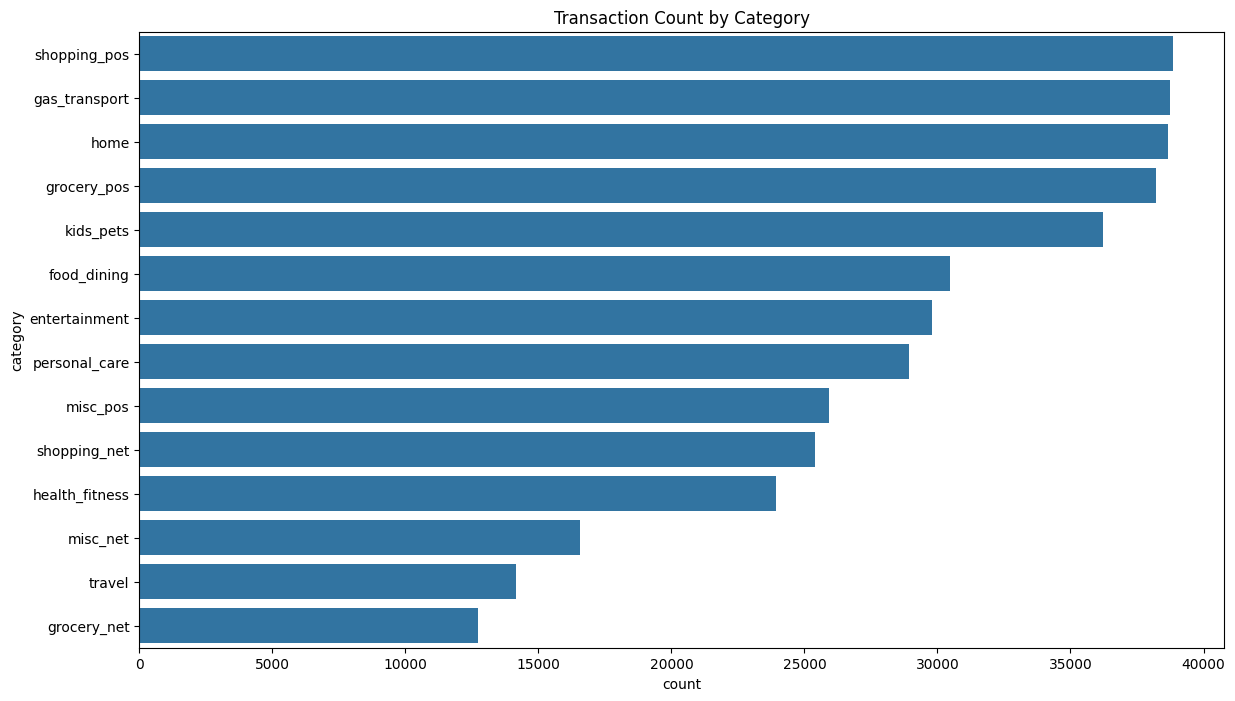

In [26]:
plt.figure(figsize=(14, 8))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Transaction Count by Category')
plt.show()

*'shopping_pos' has the highest Transaction Count.*

##### Distribution of transaction amounts per category

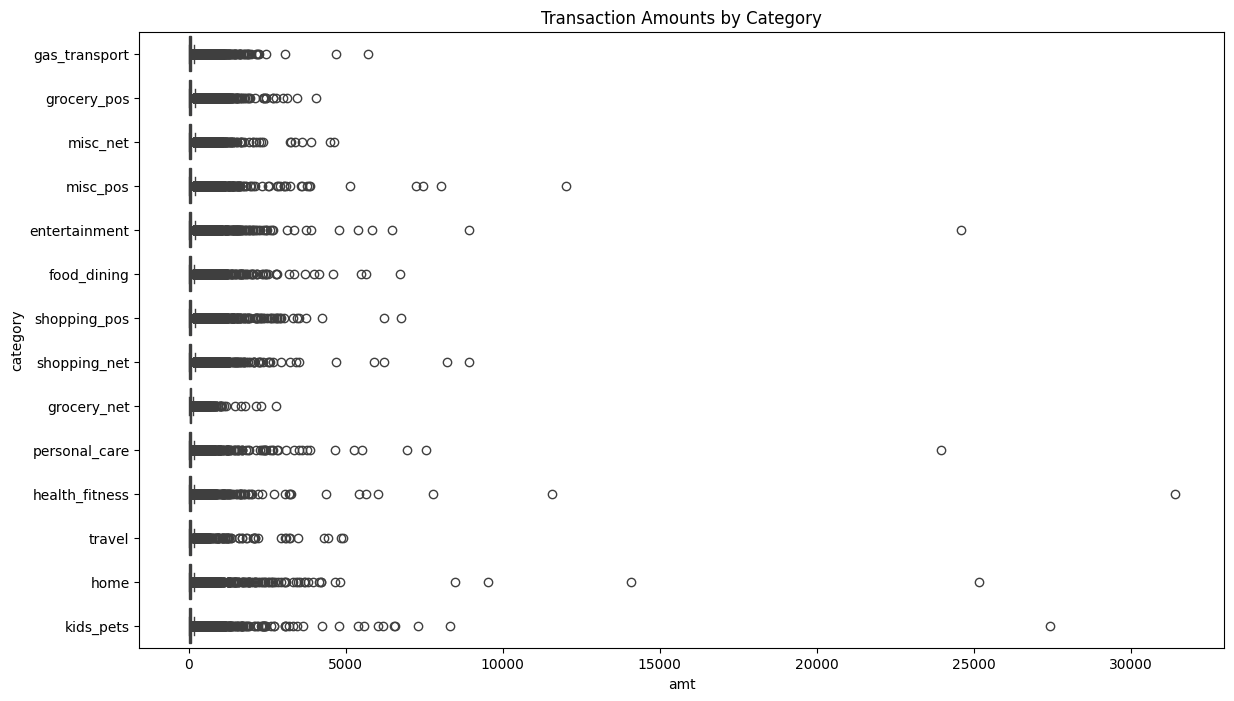

In [27]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='amt', y='category', data=df)
plt.title('Transaction Amounts by Category')
plt.show()

##### Average transaction amount per category

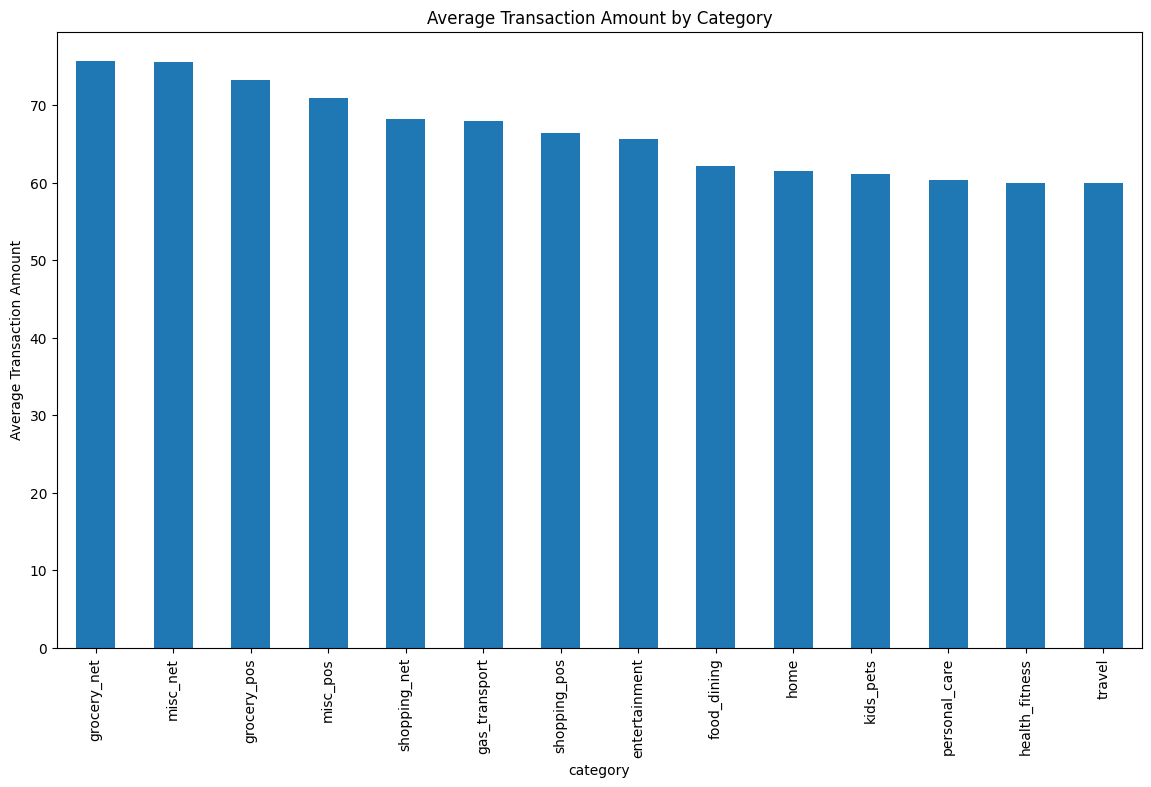

In [28]:
category_avg = df.groupby('category')['amt'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
category_avg.plot(kind='bar')
plt.title('Average Transaction Amount by Category')
plt.ylabel('Average Transaction Amount')
plt.show()

##### Distribution of variable 'is_fraud'

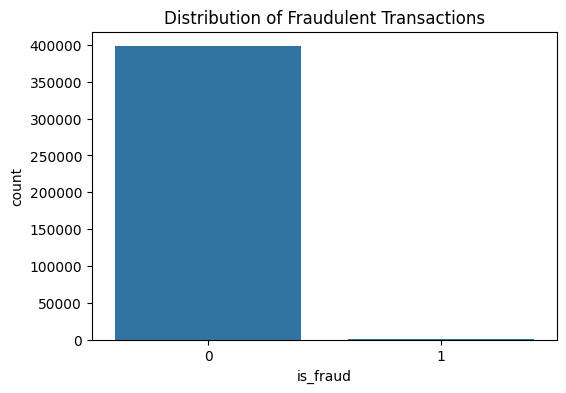

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraudulent Transactions')
plt.show()

*This is highly imbalanced class data.*

##### Fraud transactions by category

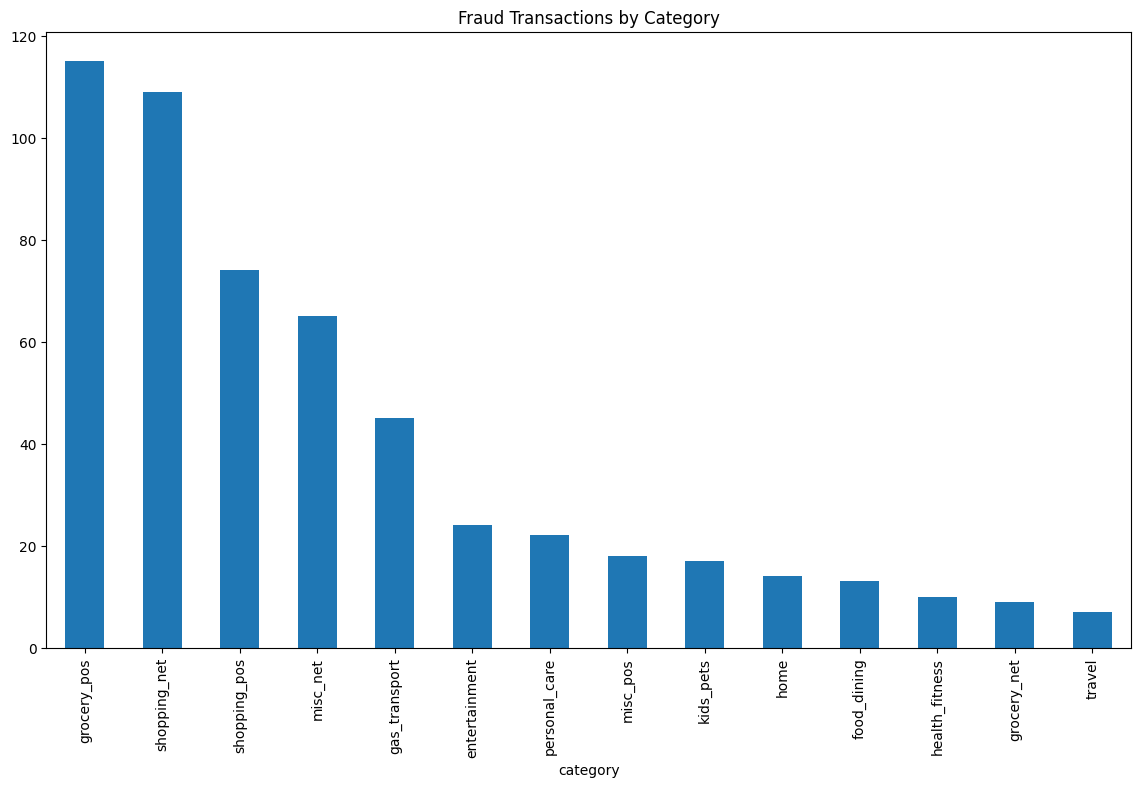

In [30]:
fraud_by_category = df[df['is_fraud'] == 1]['category'].value_counts()
plt.figure(figsize=(14, 8))
fraud_by_category.plot(kind='bar')
plt.title('Fraud Transactions by Category')
plt.show()

*grocery_pos and shopping_net has more number of fraud transactions compared to other categories*

### Geographical Analysis

##### Box plot for merchant latitude

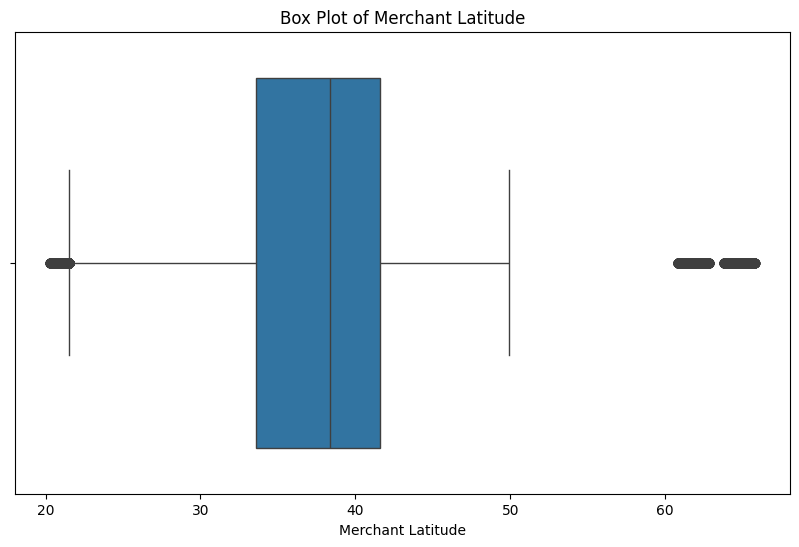

In [31]:
plt.figure(figsize=(10,6))
sns.boxplot(x='merch_lat', data=df)
plt.title('Box Plot of Merchant Latitude')
plt.xlabel('Merchant Latitude')
plt.show()

*Latitude values far from the average or expected range (e.g., very high or low latitudes) -- outliers.*

##### Box plot for merchant longitude

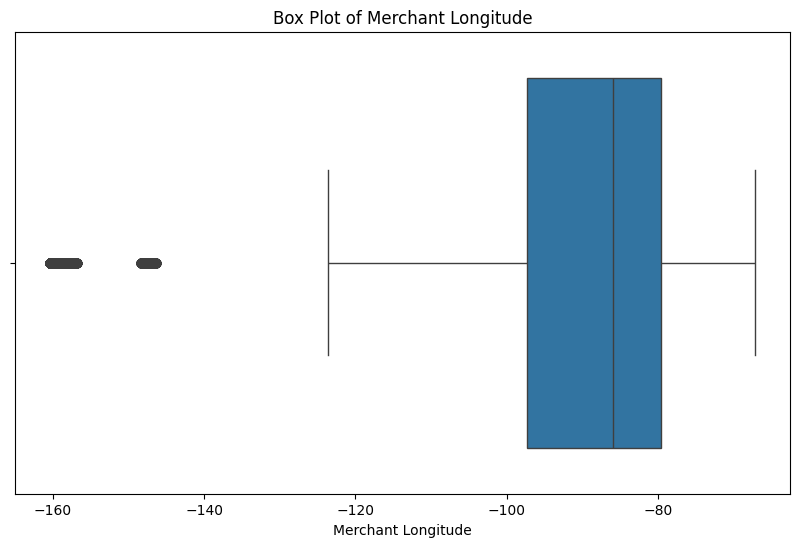

In [32]:
plt.figure(figsize=(10,6))
sns.boxplot(x='merch_long', data=df)
plt.title('Box Plot of Merchant Longitude')
plt.xlabel('Merchant Longitude')
plt.show()

*Longitude values far from the average, especially those near the extremes -- outliers.*

##### Transactions by merch_lat and differentiating Fraud transactions

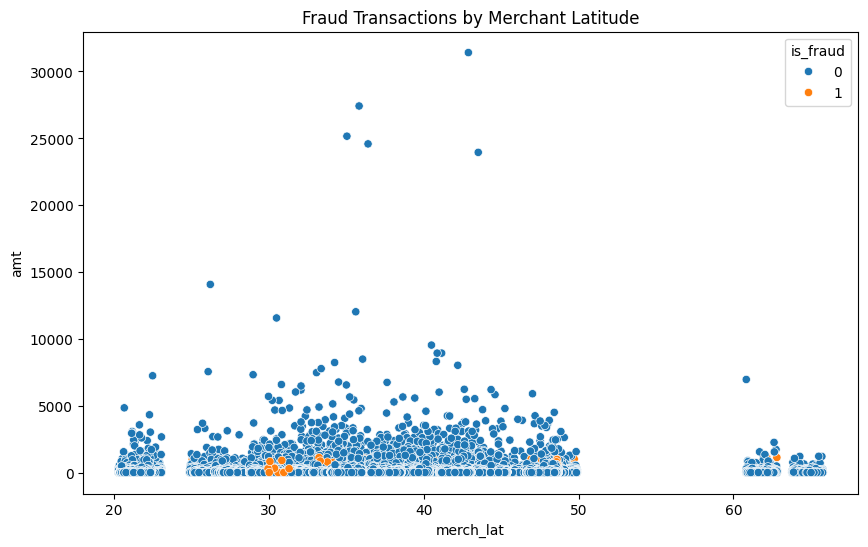

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='merch_lat', y='amt', hue='is_fraud', data=df)
plt.title('Fraud Transactions by Merchant Latitude')
plt.show()

*The majority of transactions (both fraudulent and non-fraudulent) are concentrated particularly between approximately 30 to 50 degrees. fraudulent transactions seem to cluster slightly more around the lower latitude range (around 30 degrees). There are several high-value transactions (above $10,000) that are non-fraudulent.*

##### Transactions by merch_long and differentiating Fraud transactions

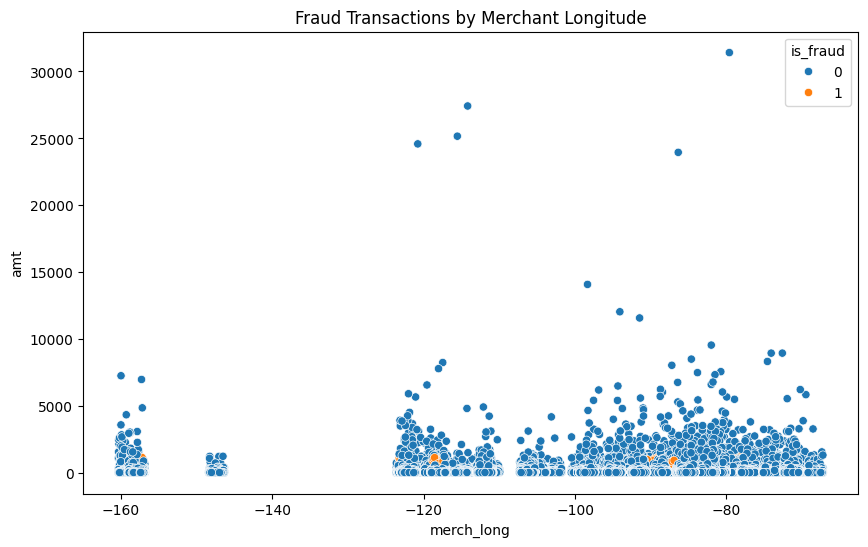

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='merch_long', y='amt', hue='is_fraud', data=df)
plt.title('Fraud Transactions by Merchant Longitude')
plt.show()

*The majority of transactions (both fraudulent and non-fraudulent) are concentrated particularly between approximately -120 to -80 degrees. There are several high-value transactions (above $10,000) that are non-fraudulent.*

##### Scatter plot of transactions by merchant latitude and longitude

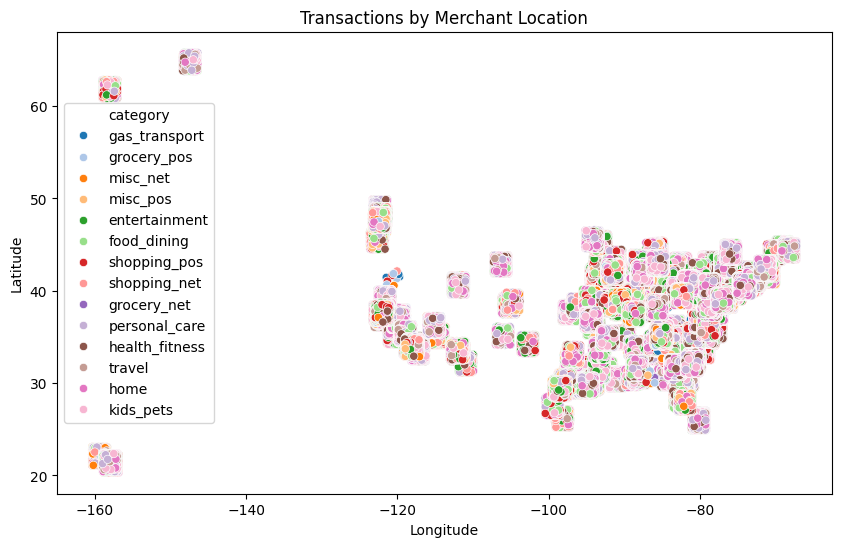

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='merch_long', y='merch_lat', hue='category', palette='tab20', data=df)
plt.title('Transactions by Merchant Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

*The majority of transactions are concentrated within the geographical bounds of the central and eastern regions.*

##### Heatmap of transaction density based on geographical location

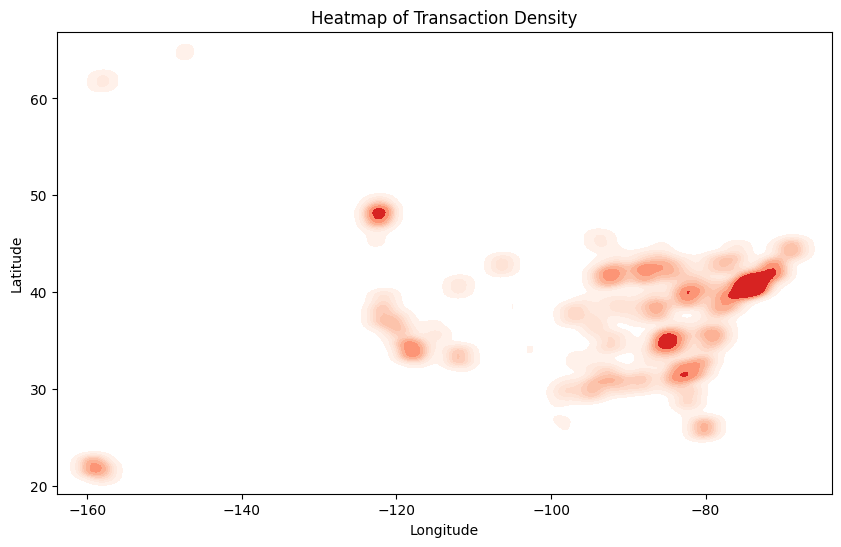

In [36]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df['merch_long'], y=df['merch_lat'], cmap='Reds', fill=True, bw_adjust=0.5)
plt.title('Heatmap of Transaction Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

*There is a significant concentration of transactions around the latitudes of 30 to 40 degrees and longitudes of -100 to -80 degrees. There are several areas with low transaction densities around -160 longitude and around 60 latitude.*

#### Time-based Analysis

##### Distribution of transactions over time

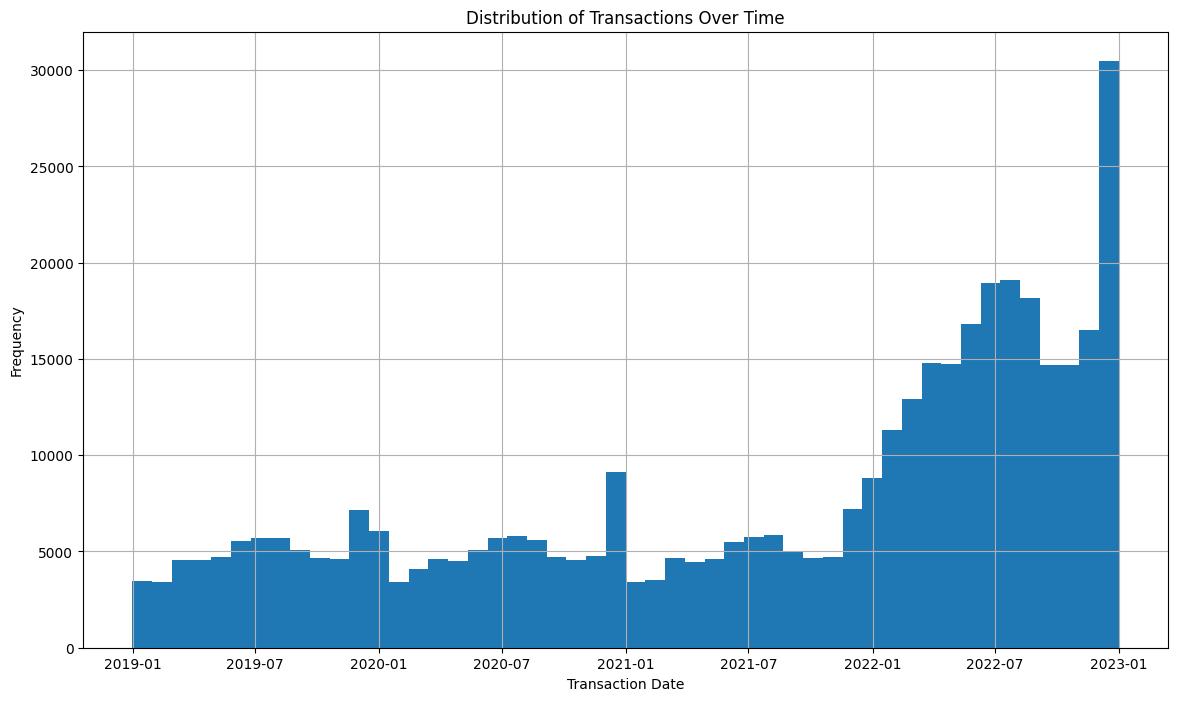

In [37]:
# Convert UNIX time to datetime
df['trans_date'] = pd.to_datetime(df['unix_time'], unit='s')

plt.figure(figsize=(14, 8))
df['trans_date'].hist(bins=50)
plt.title('Distribution of Transactions Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Frequency')
plt.show()

##### Transactions by month

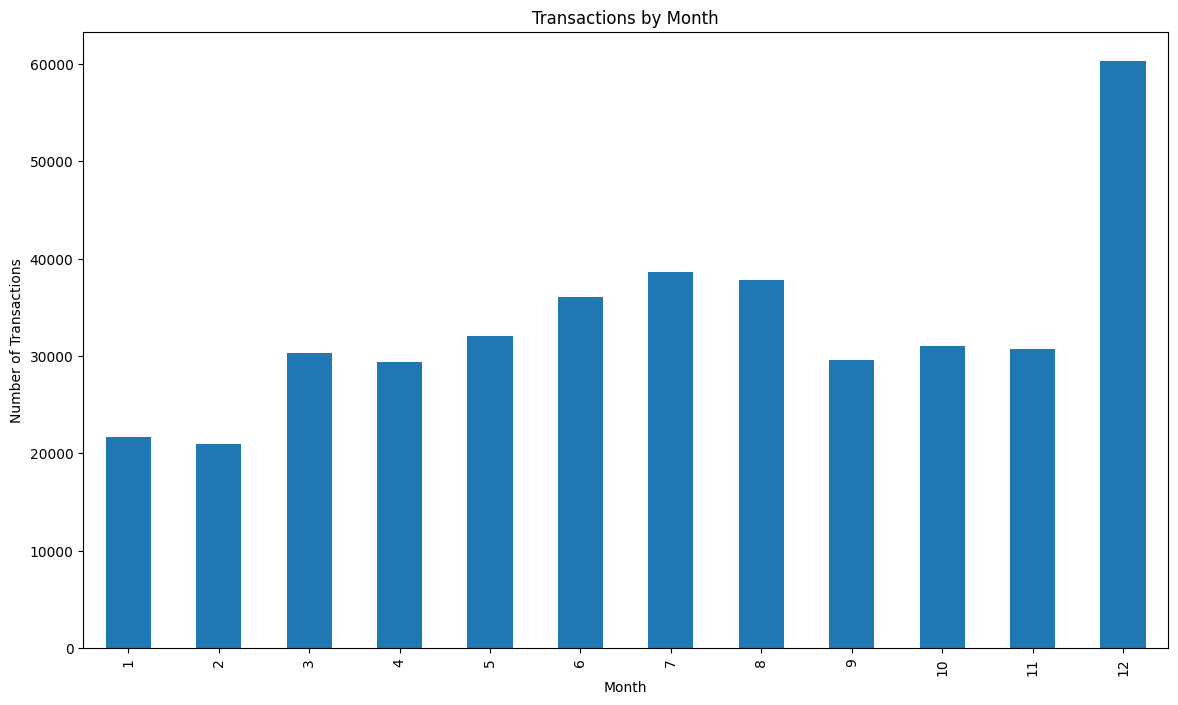

In [38]:
df['month'] = df['trans_date'].dt.month

transactions_per_month = df['month'].value_counts().sort_index()
plt.figure(figsize=(14, 8))
transactions_per_month.plot(kind='bar')
plt.title('Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

*Highest number of Transactions are in month of December and Lowest number of Transactions happens in February.*

##### Transactions by day of the week

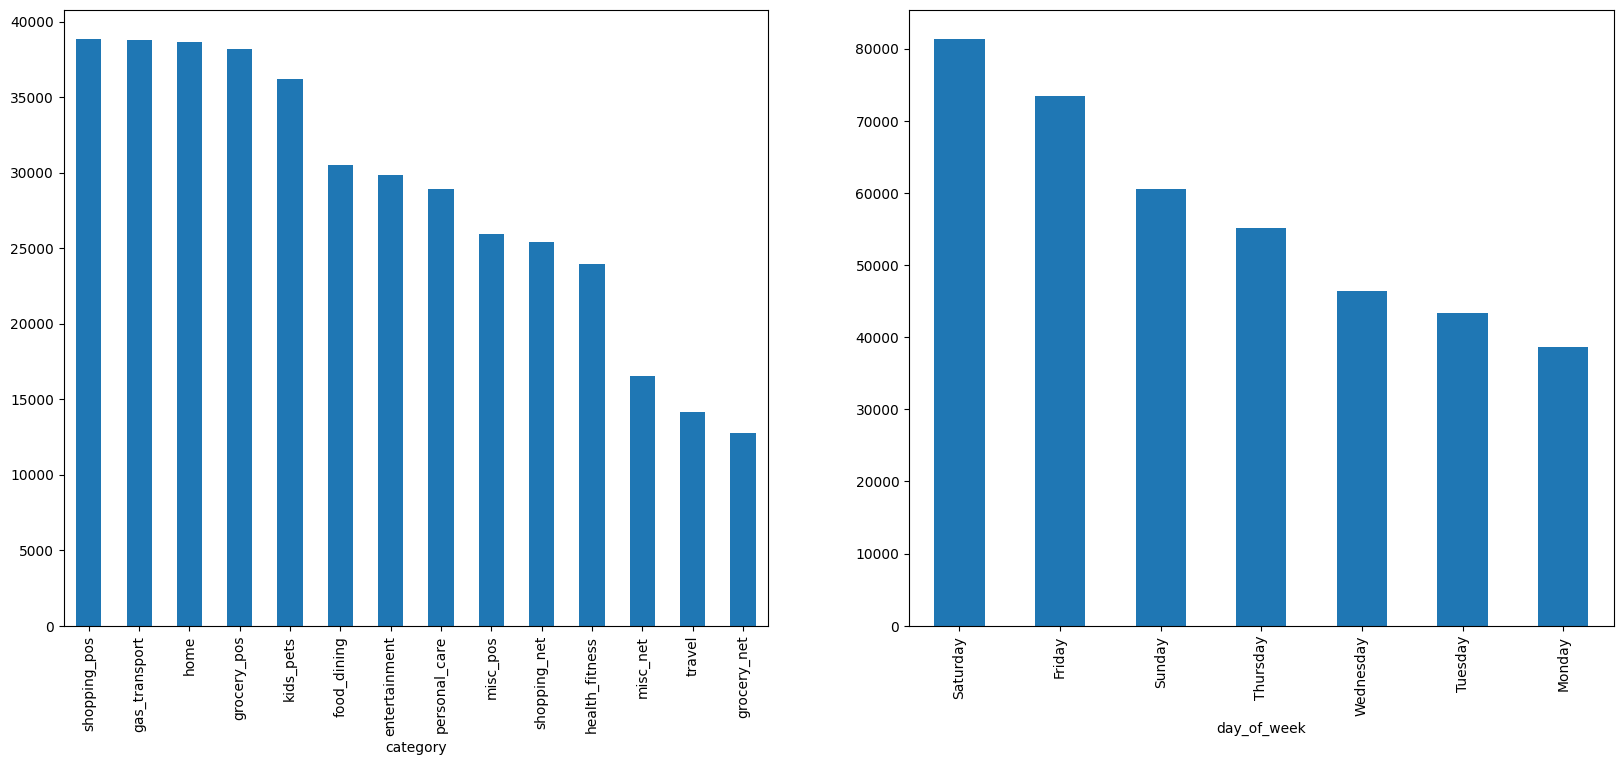

In [39]:
# Derive Day of Week from 'Transaction Time' Feature
df['day_of_week'] = df['trans_date'].dt.day_name()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
df['category'].value_counts().plot.bar();
plt.subplot(1,2,2)
df['day_of_week'].value_counts().plot.bar();

*   Saturday has highest amount of transactions of a week.
*   For shopping_pos, gas_transport and home purposes includes the most Credit card transactions.
*   For grocery_net purpose customers used the least amount of credit card transactions.

##### Highest number of Transactions

In [40]:
highest_transactions = df['merchant'].value_counts().idxmax()
print(f'The merchant with the highest number of transactions is: {highest_transactions}')

The merchant with the highest number of transactions is: Johnson LLC


##### Which category of merchant has the highest credit card transactions

In [41]:
highest_transactions_category = df['category'].value_counts().idxmax()
print(f'The category with the highest number of transactions is: {highest_transactions_category}')

The category with the highest number of transactions is: shopping_pos


##### Lowest number of Transactions

In [42]:
lowest_transactions = df['merchant'].value_counts().idxmin()
print(f'The merchant with the lowest number of transactions is: {lowest_transactions}')

The merchant with the lowest number of transactions is: Oliver, Benjamin and Wu


#### Relationship between different features

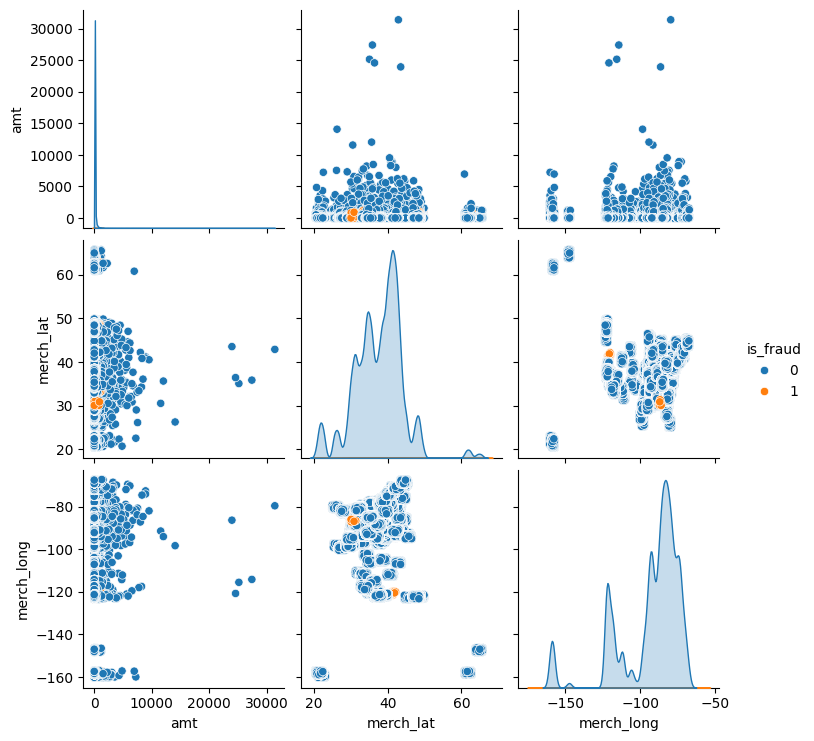

In [43]:
sns.pairplot(df[['amt', 'merch_lat', 'merch_long', 'is_fraud']], hue='is_fraud')
plt.show()

#### Customer Segmentation Features


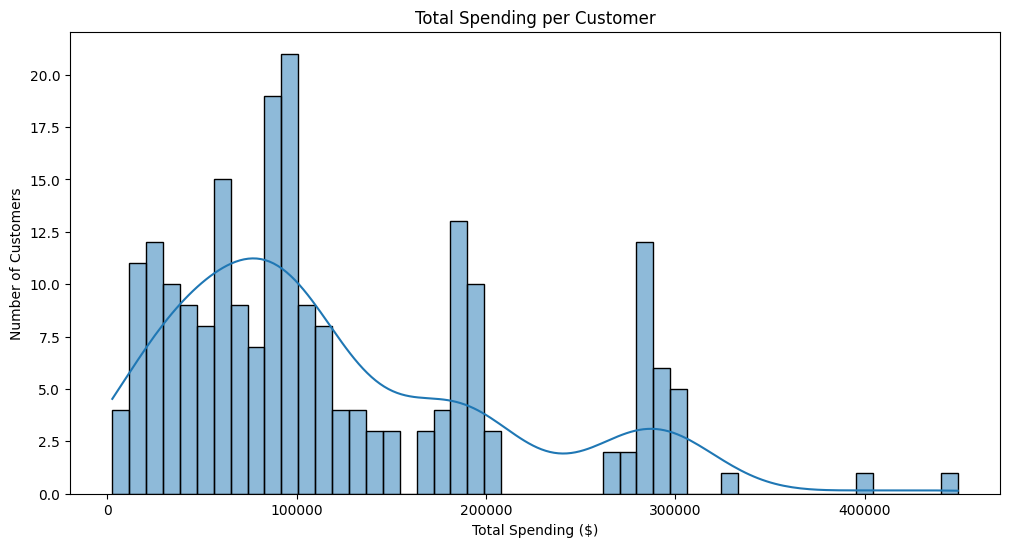

In [44]:
# Assuming 'acct_num' is unique per customer
customer_spending = df.groupby('acct_num')['amt'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.histplot(customer_spending, bins=50, kde=True)
plt.title('Total Spending per Customer')
plt.xlabel('Total Spending ($)')
plt.ylabel('Number of Customers')
plt.show()

*The histogram appears to have multiple peaks at different spending levels, suggesting distinct groups of customers with different spending behaviors.*

*  The first major peak is around the 100,000 mark, indicating a significant number of customers with spending levels around this amount.
*  Another noticeable peak is around the 200,000 mark.
*  Smaller peaks are observed around 300,000 and higher, indicating fewer but significant high-spending customers.
*  The peaks around 200,000 and 300,000 indicate the presence of high spenders.
*  A small number of customers spend between 400,000 to 500,000. These outliers represent very high spenders, likely VIP or premium customers.

##### Transaction Counts per Customer

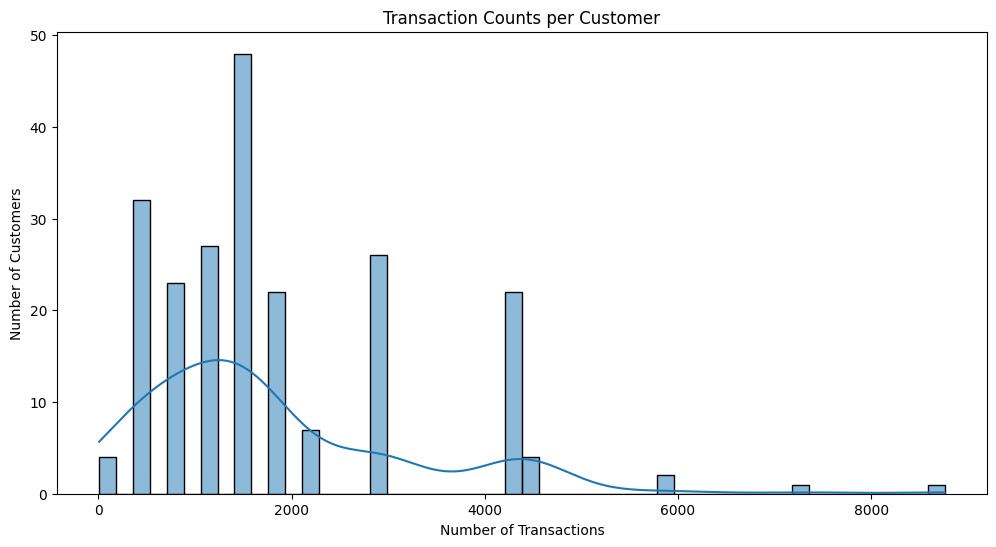

In [45]:
customer_transaction_counts = df['acct_num'].value_counts()
plt.figure(figsize=(12,6))
sns.histplot(customer_transaction_counts, bins=50, kde=True)
plt.title('Transaction Counts per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

* The first major peak is around 1,000 to 2,000 transactions. There is a substantial number of customers with transaction counts ranging from 0 to 2,000. This segment likely includes casual or less frequent users.
* Another noticeable peak is around 4,000 transactions, with moderate transaction frequency.
* There are fewer customers with transaction counts above 6,000, indicating high-frequency users or possibly businesses with frequent transactions.

#### Heatmap of correlations

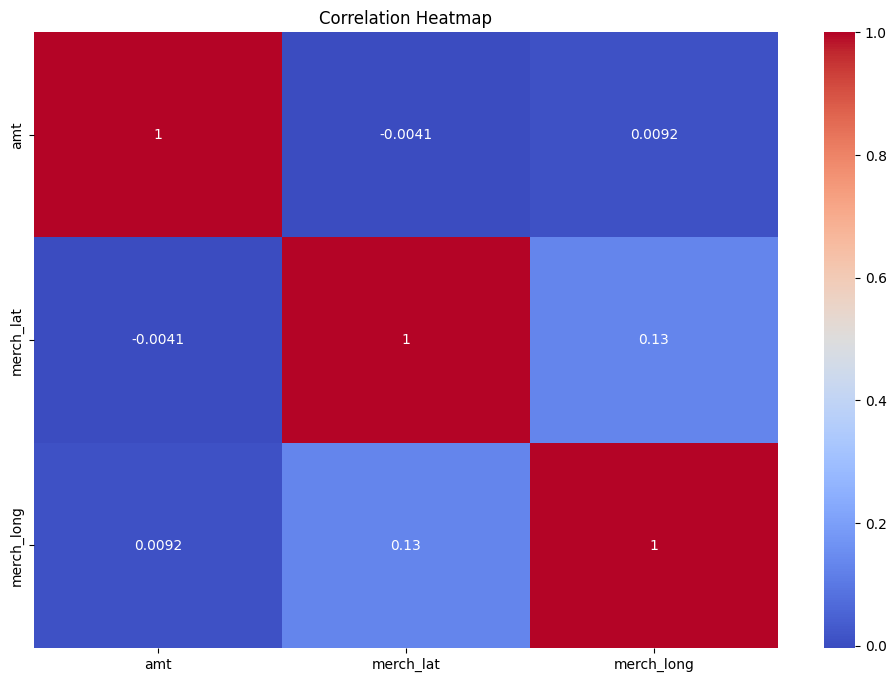

In [46]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[['amt', 'merch_lat', 'merch_long']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

* `amt` and `merch_lat`: The correlation coefficient is -0.0041, which is very close to zero. This indicates that there is no significant linear relationship between the transaction amount and the merchant's latitude.
* `amt` and `merch_long`: The correlation coefficient is 0.0092, also very close to zero. This indicates that there is no significant linear relationship between the transaction amount and the merchant's longitude.
* `merch_lat` and `merch_long`: The correlation coefficient between `merch_lat` and `merch_long` is 0.13. This indicates a weak positive correlation, suggesting that there is a slight tendency for merchants located at higher latitudes to also be located at higher longitudes.

*Since there is no significant correlation between the transaction amount and the merchant's geographical location (both latitude and longitude), we can infer that the transaction amounts are relatively independent of where the merchants are located. This suggests that spending behavior is not geographically constrained in a linear fashion.*

### 5. Prepare Data

In [47]:
df_cleaned = df.copy()

##### Remove Outliers

In [48]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for 'amt', 'merch_lat', and 'merch_long'
df_cleaned = remove_outliers(df_cleaned, 'amt')
df_cleaned = remove_outliers(df_cleaned, 'merch_lat')
df_cleaned = remove_outliers(df_cleaned, 'merch_long')

In [49]:
# Calculate the total number of transactions per customer
customer_transaction_counts = df_cleaned.groupby('acct_num')['trans_num'].count().reset_index()
customer_transaction_counts.columns = ['acct_num', 'transaction_count']

# Merge this data back into the original DataFrame
df_cleaned = df_cleaned.merge(customer_transaction_counts, on='acct_num', how='left')

##### Select relevant features

In [50]:
X = df_cleaned[['amt', 'merch_lat', 'merch_long', 'category', 'is_fraud', 'transaction_count']]

*   Amount (`amt`) represents the transaction amount, which is a primary indicator of spending behavior. Differences in transaction amounts can help identify customers with varying spending capacities and preferences.
*   Merchant Latitude (`merch_lat`) and Longitude (`merch_long`) provide geographical information. They help in identifying spatial patterns in spending behavior and potential regional preferences.
*   Different categories of merchants where transactions occur can provide insights into customer preferences and spending habits.
*   `is_fraud` can help identify segments with different levels of risk and tailor marketing strategies accordingly.
*   The number of transactions per customer can indicate engagement level and help differentiate between high-frequency and low-frequency customers.
*   Features related to Identifiers have been dropped as they are not neccessary and the unix times are mostly unique for each case, thus they are not used.

In [51]:
# List of categorical columns for one hot encoding
categorical_columns = [col for col in X.columns if X.dtypes[col] == 'object']

# List of numerical columns to standardized data
numerical_columns = [col for col in X.columns if (X.dtypes[col] != 'object')]

print('Numerical Features are : ',numerical_columns)
print('Categorical Features are : ',categorical_columns)

Numerical Features are :  ['amt', 'merch_lat', 'merch_long', 'is_fraud', 'transaction_count']
Categorical Features are :  ['category']


#### One-hot encode the categorical feature and standardizing numerical feature

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['amt', 'merch_lat', 'merch_long', 'is_fraud', 'transaction_count']),
        ('cat', OneHotEncoder(), ['category'])
    ])

#### Create a pipeline to standardize and transform the data

In [53]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#### Fit the pipeline and transform the features

In [54]:
scaled_X = pipeline.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

#### Determine the optimal number of clusters using the Elbow Method

In [55]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state=42)
    kmeans.fit(scaled_X)
    sse.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

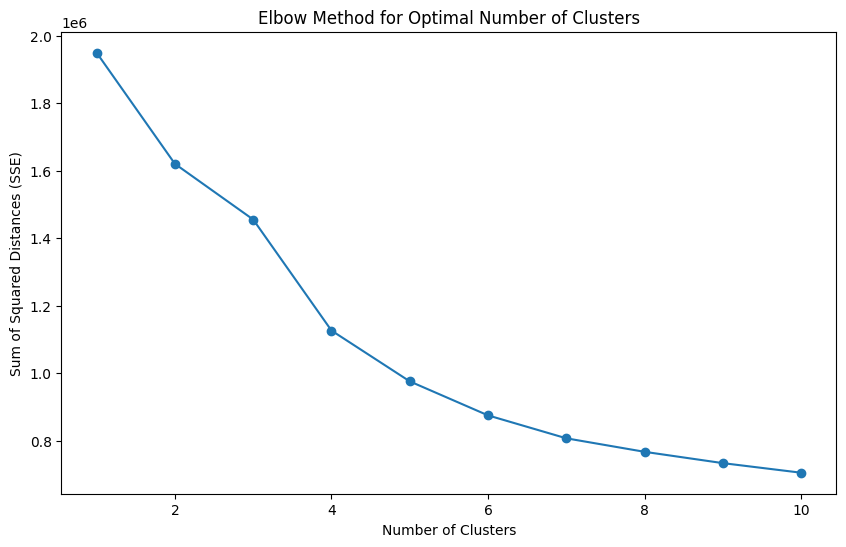

In [56]:
# Plot the Elbow Method results
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.show()

*The optimal number of clusters for the K-means clustering model appears to be 5. This point marks a significant decrease in SSE before the curve starts to flatten out.*

In [57]:
optimal_clusters = 5

### 6. Split Dataset

*In unsupervised learning tasks, such as clustering, dataset splitting into training and test sets is not typically required in the same way it is for supervised learning tasks like regression or classification, because Clustering is an unsupervised learning task where there are no labeled outputs to predict. The goal is to find inherent groupings in the data based on the input features.*

### 7. Baseline Model

In [58]:
y_central = KMeans(random_state=1)

In [60]:
y_perf = y_central.fit_predict(scaled_X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##### Davies-Bouldin Index of the Baseline Model

In [61]:
davies_bouldin_base = davies_bouldin_score(scaled_X, y_perf)

print(f'Davies-Bouldin Index of the baseline model: {davies_bouldin_base}')

Davies-Bouldin Index of the baseline model: 1.3599596261028668


### 8. Train Machine Learning Model

In [62]:
model = KMeans(n_clusters = optimal_clusters, init = 'k-means++', random_state = 42)

In [63]:
df_cleaned['cluster'] = model.fit_predict(scaled_X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 9. Assess Model Performance

In [64]:
model_perf = model.fit_predict(scaled_X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##### PCA for 2D projection and visualization

In [65]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_X)
df_cleaned['pca_one'] = pca_components[:, 0]
df_cleaned['pca_two'] = pca_components[:, 1]

##### Plotting the clusters for the optimized model

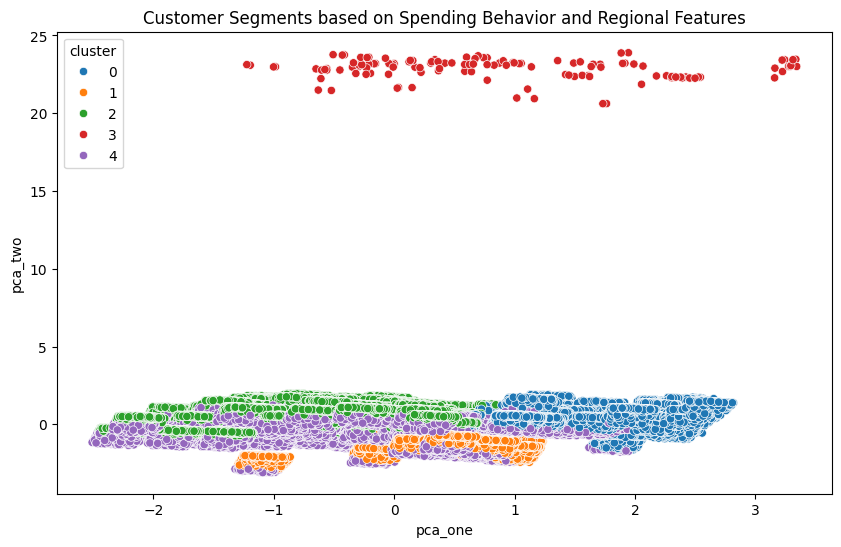

In [66]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='pca_one', y='pca_two', hue='cluster', palette='tab10', data=df_cleaned)
plt.title('Customer Segments based on Spending Behavior and Regional Features')
plt.show()

#### Davies-Bouldin Index of the Final Model

In [69]:
davies_bouldin = davies_bouldin_score(scaled_X, model_perf)

print(f'Davies-Bouldin Index of the final model: {davies_bouldin}')

Davies-Bouldin Index of the final model: 1.2915374847165855


#### Display the average of all features for each group

In [68]:
# Display the average of all numeric features for each group
numeric_columns = ['amt', 'merch_lat', 'merch_long', 'is_fraud', 'transaction_count']
cluster_means_numeric = df_cleaned.groupby('cluster')[numeric_columns].mean()

# Display the mode of all categorical features for each group
categorical_columns = ['category']
cluster_modes_categorical = df_cleaned.groupby('cluster')[categorical_columns].agg(lambda x: x.mode()[0])

# Combine numeric and categorical summaries
cluster_summary = pd.concat([cluster_means_numeric, cluster_modes_categorical], axis=1)

print("Average of all features for each group:")
print(cluster_summary)

Average of all features for each group:
                amt  merch_lat  merch_long  is_fraud  transaction_count  \
cluster                                                                   
0         44.128572  33.270580 -106.127215       0.0        1641.894975   
1         41.584172  32.509295  -85.439080       0.0        4477.155717   
2         21.807929  40.160720  -81.514818       0.0        2202.618149   
3         23.925397  37.253364  -87.707153       1.0        1345.341270   
4        100.519188  39.443277  -82.870038       0.0        2513.407087   

              category  
cluster                 
0                 home  
1        gas_transport  
2                 home  
3          grocery_pos  
4          grocery_pos  
